### Step 1 (Define the datasets)

In [33]:
from torchvision.datasets import CIFAR10  # We downloaded the CIFAR-10 and to extract the data we use this library
from torchvision import transforms # To do transform operations on the data we use this library
import torch # To use the PyTorch library we import it
import torch.nn as nn # To use the neural network module we import it

In [34]:
# CIFAR-10 Mean and Std
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

# TEST TRANSFORM MUST HAVE NORMALIZATION TOO
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Set download=True to be safe
train_dataset = CIFAR10(root="dataset", train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root="dataset", train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [35]:
# Let's check the number of samples in the training and testing datasets.
len(train_dataset), len(test_dataset)

(50000, 10000)

### Step 2 (Visualize the samples from dataset)

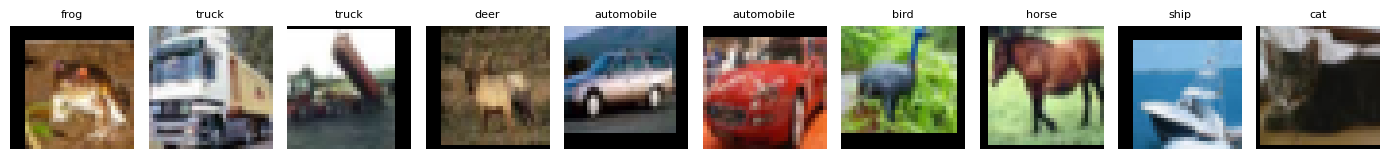

In [36]:
# For data visualization we use the matplotlib library
import matplotlib.pyplot as plt

# We need to unnormalize the images to visualize them properly. 
# The mean and std values are the same as those used in the normalization step of the transformations.
mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3, 1, 1)
std = torch.tensor((0.2023, 0.1994, 0.2010)).view(3, 1, 1)

plt.figure(figsize=(14, 3))
labels = train_dataset.classes

for i in range(10):
    plt.subplot(1, 10, i + 1)
    image, label = train_dataset[i]
    image = (image * std + mean).clamp(0, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(labels[label], fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [37]:
# Let's check the shape and type of the first image and label in the training dataset to ensure they are as expected.
image, label = train_dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")
print(f"Image type: {type(image)}, Label type: {type(label)}")

Image shape: torch.Size([3, 32, 32]), Label: 6
Image type: <class 'torch.Tensor'>, Label type: <class 'int'>


### Step 3 (Patchify Operation)

In [38]:
# We define the PatchEmbedding class, which is a crucial component of the Vision Transformer architecture.
# Patch embedding is the process of dividing the input image into smaller patches.
# Then projecting each patch into a higher-dimensional space to create a sequence of embeddings.
# That can be fed into the transformer model.
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embedding_dimension):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, embedding_dimension, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

### Step 4 (CLS & Position)

In [39]:
# Now it is time to implement the class token and positional embedding.
# The class token is a special token that is added to the beginning of the input sequence.
# It is used to aggregate information from the entire sequence and is typically used for classification tasks.
# Positional embedding is added to the input sequence to provide information about the position of each token in the sequence.
# Since the transformer architecture does not have any inherent notion of order.
class ClsAndPosition(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim) * 0.02)

    def forward(self, x):
        B = x.shape[0]
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls, x), dim=1)
        x = x + self.pos_embed
        return x

### Step 5 (Attention Setup)

In [40]:
# Multi-Head Self-Attention lets each token attend to all other tokens.
# Using multiple heads allows the model to learn different interaction patterns in parallel.
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dimension, num_heads):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.num_heads = num_heads
        self.head_dim = embedding_dimension // num_heads
        self.qkv_proj = nn.Linear(embedding_dimension, embedding_dimension * 3)
        self.out_proj = nn.Linear(embedding_dimension, embedding_dimension)
        
    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(batch_size, seq_length, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).reshape(batch_size, seq_length, self.embedding_dimension)
        output = self.out_proj(attn_output)
        return output

In [41]:
# Now we will implement the MLP (Multi-Layer Perceptron) class, which is used in the transformer architecture after the attention mechanism.
# The MLP consists of two linear layers with a GELU activation function in between.
# The aim of the MLP is to further process the output of the attention mechanism and introduce non-linearity into the model.
class MLP(nn.Module):
    def __init__(self, embedding_dimension, mlp_dimension):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dimension, mlp_dimension)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(mlp_dimension, embedding_dimension)
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x

In [42]:
# Finally, we will implement the Block class, which represents a single transformer block.
# Each block consists of a multi-head self-attention layer followed by an MLP, with layer normalization and residual connections.
# The aim of the Block class is to encapsulate the operations of a single transformer block.
# Making it easier to stack multiple blocks together to build the full Vision Transformer model.
class Block(nn.Module):
    def __init__(self, embedding_dimension, num_heads, mlp_dimension):
        super().__init__()
        self.msa = MultiHeadSelfAttention(embedding_dimension, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dimension)
        self.mlp = MLP(embedding_dimension, mlp_dimension)
        self.norm2 = nn.LayerNorm(embedding_dimension)
    def forward(self, x):
        x = x + self.msa(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [43]:
# Now we will implement the ViT (Vision Transformer) class, which is the main model that combines all the components we have defined so far.
# The ViT class takes the input image, applies patch embedding, adds the class token and positional embedding, and then passes the sequence through multiple transformer blocks.
class ViT(nn.Module):
    def __init__(self,img_size,patch_size,in_channels,embed_dim,num_heads,mlp_dim,depth,num_classes):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_pos = ClsAndPosition(self.patch_embed.num_patches, embed_dim)
        self.blocks = nn.ModuleList([Block(embed_dim, num_heads, mlp_dim) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.cls_pos(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        cls_out = x[:, 0]
        logits = self.head(cls_out)
        return logits

### Step 6 (Training Loop)


In [44]:
# Now we will set the device to run our model on. We will check if a GPU is available and use it if possible
# Otherwise we will fall back to using the CPU.
import torch.optim as optim

device = torch.device(
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)
print(f"Using device: {device}")

Using device: mps


In [45]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

model = ViT(
    img_size = 32,
    patch_size=4, 
    in_channels=3, 
    embed_dim=256,    
    depth=6,        
    num_heads=4,      
    mlp_dim=512,      
    num_classes=10
)

model.apply(init_weights)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

print("Model Initialized with Custom Weights.")

Model Initialized with Custom Weights.


In [46]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [47]:
num_epochs = 20
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
}

best_acc = 0.0
checkpoint_path = 'vit_cifar10_best.pt'

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), checkpoint_path)

    print(f"Epoch [{epoch + 1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc * 100:.2f}%")

print(f'Best test accuracy: {best_acc * 100:.2f}%')
print(f'Best checkpoint saved to: {checkpoint_path}')


Epoch [1/20] | Train Loss: 1.8571, Train Acc: 35.46% | Test Loss: 1.6793, Test Acc: 45.31%
Epoch [2/20] | Train Loss: 1.5959, Train Acc: 49.03% | Test Loss: 1.5782, Test Acc: 49.90%
Epoch [3/20] | Train Loss: 1.4760, Train Acc: 54.87% | Test Loss: 1.4222, Test Acc: 57.93%
Epoch [4/20] | Train Loss: 1.3930, Train Acc: 58.98% | Test Loss: 1.3312, Test Acc: 62.42%
Epoch [5/20] | Train Loss: 1.3380, Train Acc: 61.80% | Test Loss: 1.3015, Test Acc: 63.34%
Epoch [6/20] | Train Loss: 1.2810, Train Acc: 64.18% | Test Loss: 1.2422, Test Acc: 66.22%
Epoch [7/20] | Train Loss: 1.2292, Train Acc: 66.77% | Test Loss: 1.2305, Test Acc: 66.66%
Epoch [8/20] | Train Loss: 1.1856, Train Acc: 68.81% | Test Loss: 1.1830, Test Acc: 68.84%
Epoch [9/20] | Train Loss: 1.1510, Train Acc: 70.39% | Test Loss: 1.1493, Test Acc: 70.56%
Epoch [10/20] | Train Loss: 1.1113, Train Acc: 72.24% | Test Loss: 1.1061, Test Acc: 73.15%
Epoch [11/20] | Train Loss: 1.0722, Train Acc: 74.08% | Test Loss: 1.0971, Test Acc: 73.2

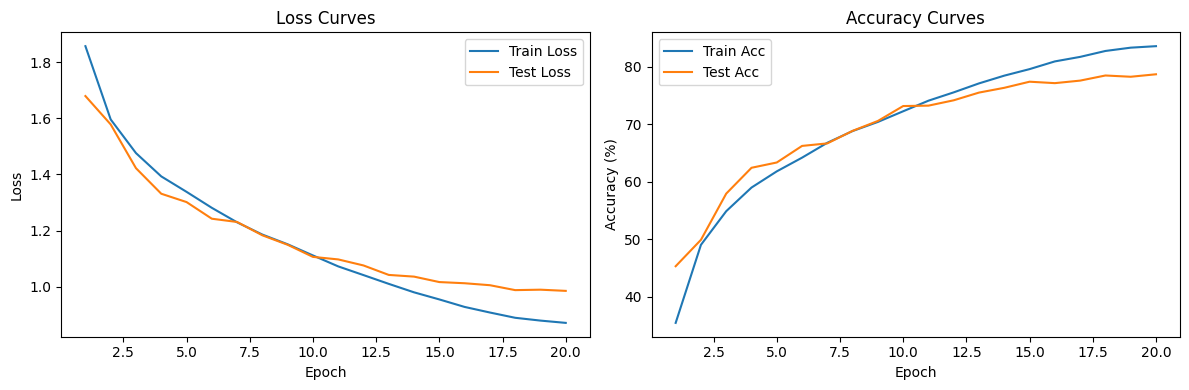

In [48]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, [x * 100 for x in history['train_acc']], label='Train Acc')
plt.plot(epochs, [x * 100 for x in history['test_acc']], label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()
